In [1]:
from IPython.display import display, HTML, clear_output
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 95%; }    div#maintoolbar-container { width: 99%; }
</style>
"""))
import sys
if (__name__ == '__main__') and (sys.platform == 'darwin'):
    import multiprocessing as mp; mp.set_start_method('forkserver') 
import pandas as pd
import numpy as np
import scipy, itertools, datetime, calendar, workdays, glob
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, neural_network, tree, linear_model, kernel_ridge, neighbors, svm, tree
from sklearn import preprocessing, metrics, decomposition, preprocessing, model_selection, feature_selection
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from dateutil.parser import parse
from datetime import timedelta
from collections import Counter
from tqdm import tnrange, tqdm_notebook
from clf_fitter import iter_fit, iter_test, iter_predict
from MyClf import MyClf
from helper_functions import *
%matplotlib inline
try:
    import pdblp
except:
    pass

## Feature Build

In [2]:
##########################################################################################################################################################
## Transform and build the feature set from raw bloomberg data contained in pickle file 'historical_data1.pickle'
##########################################################################################################################################################

EQUITY_TICKERS   = ['spy', 'iwm', 'mdy', 'hyg'] #'xiv', 'vxx', 'tvix', 
INDUSTRY_TICKERS = ['xle', 'xlb', 'xlf', 'iyz', 'xlv', 'xlk', 'xlp', 'xlu', 'xly', 'xli'] #'xiv', 'vxx', 'tvix', 
INDEX_TICKERS    = ['spvixstr', 'sx5e', 'vix', 'pcrteqty', 'vvix', 'vxv', 'vxth', 'rxm', 'rvx', 'vxn',
                    'tyvix', 'jpmvxyg7', 'jpmvxyem', 'tradhigh', 'tradlows', 'cvxftncn', 'vxxiv', 'cesiusd', 'cesig10']
                    # 'vcac', 'v2x', 'vhsi', 'vaex', 'vimex', 'tradcads', 'vnky', 'vftse', 'vkospi'
MACRO_TICKERS    = ['nfp tch', 'injcjc', 'usmmmnch', 'injcsp', 'ip chng', 'consexp', 'dgnoxtch', 'pitlchng', 'lei chng', 'napmpmi', 'napmnmi', 'conssent', 'concconf']
VIX_FUTURES      = ['ux1', 'ux2', 'ux3', 'ux4', 'ux5', 'ux6', 'ux7']
VOL_FIELDS       = ['30DAY_IMPVOL_97.5%MNY_DF', '30DAY_IMPVOL_102.5%MNY_DF', '30DAY_IMPVOL_95.0%MNY_DF', '30DAY_IMPVOL_105.0%MNY_DF','3MTH_IMPVOL_95.0%MNY_DF', '3MTH_IMPVOL_105.0%MNY_DF']
OTHER            = ['weight', 'contract_days_length', 'contract_days_left']
equity_tks       = [tk + ' equity' for tk in EQUITY_TICKERS]
industry_tks     = [tk + ' equity' for tk in INDUSTRY_TICKERS]
index_tks        = [tk + ' index' for tk in INDEX_TICKERS]
macro_tks        = [tk + ' index' for tk in MACRO_TICKERS]
spy_vol_tks      = ['SPY_' + tk for tk in VOL_FIELDS]
ux_weighted_tks  = ['ux_weighted', 'ux_weighted_2', 'ux_weighted_3', 'ux_weighted_4', 'ux_weighted_5', 'ux_weighted_6']
other_tks        = ['ctg_curvature', 'ux_weighted', 'ux_weighted_2', 'ux_weighted_3', 'ux_weighted_4', 'ux_weighted_5', 'ux_weighted_6', 'ctg_weighted', 'ctg_weighted_1v2', 'ctg_weighted_1d_lag', 'ux_weighted_1d_lag', 'vix_1d_lag', 'ux_wgt_prem', 'contract_days_times_premium', 'contract_days_remaining_ux2ux1_premium', 'contract_days_remaining_ux1vix_premium', 'spy_MACD', 'spy_5d_ema', 'spy_5d_rv', 'spy_10d_rv', 'spy_20d_rv', 'spy_30d_rv', 'spy_6m_rv', 'vix_spy_10rv_prem', 'vix_spy_20rv_prem', 'vix_spy_6mrv_prem', 'spy_rv_momentum', 'ctg_momentum', 'ctg_momentum_chg', 'spvixstr_1dl', 'spvixstr_2dl', 'spvixstr_3dl', 'spvixstr_4dl', 'spvixstr_5dl', 'spy_iwm_10d_corr', 'spy_mdy_10d_corr', 'spy_hyg_10d_corr', 'xle equity_pct_corr', 'xlb equity_pct_corr', 'xlf equity_pct_corr', 'iyz equity_pct_corr', 'xlv equity_pct_corr', 'xlk equity_pct_corr', 'xlp equity_pct_corr', 'xlu equity_pct_corr', 'xly equity_pct_corr', 'xli equity_pct_corr', 'spvixstr_2d_perf', 'spvixstr_3d_perf', 'spvixstr_5d_perf', 'spy_30d_skew_95_105', 'spy_30d_skew_97.5_102.5', 'spy_3m_skew_95_105']
mytks = equity_tks.copy()
mytks.extend(industry_tks)
mytks.extend(index_tks)
mytks.extend(macro_tks)
mytks.extend(spy_vol_tks)
mytks.extend(VIX_FUTURES)
mytks.extend(OTHER)

# select raw feature transformations (pct/net change, exponential moving average, etc.
# based on on the excel mapping table feature_mapping.xlsx
mapping_table = pd.read_excel('feature_mapping.xlsx', index_col=0)
feature_list = list(mapping_table[mapping_table.price == 1].index)
feature_list.extend([feature + '_chg' for feature in mapping_table[mapping_table.net_chg == 1].index])
feature_list.extend([feature + '_pct' for feature in mapping_table[mapping_table.pct == 1].index])
feature_list.extend([feature + '_ema3d' for feature in mapping_table[mapping_table.ema3d == 1].index])
feature_list.extend([feature + '_macd' for feature in mapping_table[mapping_table.macd == 1].index])
feature_list.extend([feature + '_pct_ema3d' for feature in mapping_table[mapping_table.pct_ema3d == 1].index])

# adjust for indicators with a 1 day lag
INDICATORS_WITH_LAG = ['tradhigh index', 'tradlows index'] + spy_vol_tks
features_to_pct = equity_tks + industry_tks + index_tks + macro_tks + ux_weighted_tks
features_to_chg = index_tks + macro_tks + ux_weighted_tks + spy_vol_tks + ux_weighted_tks
features_to_macd = equity_tks + index_tks + ux_weighted_tks + macro_tks
features_to_ema = equity_tks + index_tks + macro_tks + spy_vol_tks + ux_weighted_tks + other_tks + [tk + '_pct' for tk in equity_tks + industry_tks + index_tks + ux_weighted_tks]

pipeline_feature_build = Pipeline([
    ('shift_data', ShiftColumns(INDICATORS_WITH_LAG, 1)),
    ('add_vix_features', AddVIXFeatures()),
    ('add_percent_change', PercentageChange(features=features_to_pct)),
    ('fill_na', FillNA(method='ffill')),
    ('add_other_features', AddOtherFeatures()),
    ('add_net_change', NetChange()),
    ('fill_nas', FillNA(value=0)),
    ('fill_inf', FillInf(value=0)),
    ('add_macd', MACD(p1=10, p2=2, signal=2, features=features_to_macd)),
    ('add_ema', EMA(ewm=3, features=features_to_ema)),
    ('select_features', FeatureExtractor(features=feature_list)),
])

# load custom pipeline with pre-selected features for testing
my_pipeline_fs3 = joblib.load('my_pipeline_fs3.pkl')
# load a pickled grid search
gscv3 = joblib.load('gscv3.pkl')

def get_dataset(how='regression', from_date='2006-12-15', to_date=(datetime.datetime.today()-datetime.timedelta(1)).strftime('%Y%m%d'),
                y_lag=-1, y_var='spvixstr index_pct', threshold=0.00, classification_categories=[-1,1], prediction_days=1, time_step_adjustment=False):
    '''Helper function to transform the dataset for ML algo.
    
    Parameters
    ----------
    how : classification, regression, prediction
         'classification': return X and y, and forward return, where y the binary classification based on specified thresholds 
         'regression'    : return X and y, where y is the return
         'prediction'    : return dataset with only last row for prediction

    y_lag: integer, --DEPRECATED

    y_var: string, default: 'spvixstr index_pct'
        select the dependent variable
    
    threshold: float, default: 0.00
        threshold to use for classifier categorization
    
    classification_categories: list, default[-1,1]
        2 elements for binary classification
    
    prediction_days: int, default: 1
        cumulative return of y dependent variable over x number of days
    
    time_step_adjustment: bool: default: false
        adjust the time step for X so as to avoid the look-ahead bias

    Returns
    ----------
    Data frame for training/prediction.
    '''

    threshold = 0.00
    data = pd.read_pickle('historical_data1.pickle')
    data = data[mytks]
    X = pipeline_feature_build.fit_transform(data)
    y = X[y_var]
    y = y.rolling(prediction_days).apply(lambda x: np.prod(np.nan_to_num(x)+1)-1).shift(-prediction_days)
    date_mask = (data.index > from_date) & (data.index <= to_date)
    X_mask, y_mask, dates_mask = X[date_mask], y[date_mask], X.index[date_mask]
    if time_step_adjustment:
        X_mask, y_mask, dates_mask = X_mask[::prediction_days], y_mask[::prediction_days], dates_mask[::prediction_days]
    if how == 'regression':
        return X_mask, y_mask
    elif how == 'classification':
        y_clf = np.array([classification_categories[0] if y_ <= threshold else classification_categories[1] for y_ in y_mask])
        return X_mask, y_clf, y_mask
    elif how == 'prediction':
        return X.tail(1)
    else:
        raise ValueError('{} is not a valid option.'.format(how))

rand_state = 1
class_weights1 = {1: 1.05, -1: 1}
class_weights2 = {1: 1.08, -1: 1}
class_weights3 = {1: 1.15, -1: 1}

In [3]:
# Scikit-learn classifier dictionary
sk_classifiers = {    
    'Ridge1':      linear_model.RidgeClassifier(alpha=1.0, max_iter=100000, tol=1e-5, solver='lsqr', class_weight=None, fit_intercept=True, random_state=rand_state),
    'RidgeGS1':    linear_model.RidgeClassifier(alpha=25.118864315095795, max_iter=None, solver='sparse_cg', class_weight=class_weights1, random_state=rand_state, tol=0.1),
    'RidgeGS2':    linear_model.RidgeClassifier(alpha=1, max_iter=None, solver='sparse_cg', class_weight=class_weights1, random_state=rand_state, tol=0.05),
    'Logistic1':   linear_model.LogisticRegression(C=1, penalty='l1', n_jobs=-1, max_iter=100000, solver='liblinear', random_state=rand_state),
    'LogisticGS':  linear_model.LogisticRegression(C=1, penalty='l2', n_jobs=-1, class_weight=class_weights2, max_iter=100000, solver='liblinear', random_state=rand_state),
    'SVC':         svm.SVC()
#     'LinearSVC':   LogisticRegression(C=1, penalty='l1', n_jobs=-1, max_iter=100000, solver='liblinear', random_state=rand_state),
#     'BayesianRidge': BayesianRidge(n_iter=1000, tol=0.0001, alpha_1=0.001, alpha_2=0.001, lambda_1=1e-06, lambda_2=1e-06, compute_score=False, fit_intercept=True, normalize=False, copy_X=True, verbose=False),
#     'KernelRidge': KernelRidge(alpha=1, kernel='linear', gamma=None, degree=3, coef0=1, kernel_params=None),
    
#     'lol':         LogisticRegression(C=1.8991744770265189, class_weight={1: 1.15, -1: 1},
#           dual=False, fit_intercept=True, intercept_scaling=1,
#           max_iter=100000, multi_class='ovr', n_jobs=1, penalty='l1',
#           random_state=1, solver='liblinear', tol=0.0001, verbose=0,
#           warm_start=False)
#     'MLP':         MLPClassifier(hidden_layer_sizes=(500,), learning_rate_init=0.00001)
}

In [4]:
# Scikit-learn regressor dictionary
sk_regressors = {
    'ElasticNet': linear_model.ElasticNet(alpha=1e-05, copy_X=True, fit_intercept=True, l1_ratio=0.3, max_iter=100000, normalize=False, positive=False, precompute=False,
                                          random_state=1, selection='cyclic', tol=1e-05, warm_start=False),
#     'EN-R2':      linear_model.ElasticNet(alpha=0.00067584514383677496, copy_X=True, fit_intercept=True, l1_ratio=0.4774821546055622, max_iter=100000, normalize=False,
#                                      positive=False, precompute=False, random_state=1, selection='cyclic', tol=1e-5, warm_start=False),
#     'EN-Scorer':  linear_model.ElasticNet(alpha=0.00031645793551216445, copy_X=True, fit_intercept=True, l1_ratio=0.51712317704506616, max_iter=100000, normalize=False,
#                                         positive=False, precompute=False, random_state=1, selection='cyclic', tol=1e-05, warm_start=False),
    'BRidge':     linear_model.BayesianRidge(n_iter=100000, tol=1e-3, alpha_1=10**-6, alpha_2=10**-0.25, lambda_1=10**-6, lambda_2=10**-6),
    'BRidgeCV':   linear_model.BayesianRidge(alpha_1=1e-10, alpha_2=0.01, compute_score=False, copy_X=True, fit_intercept=True, lambda_1=0.01, lambda_2=1e-10, n_iter=100000,
                                          normalize=False, tol=1e-05, verbose=False),
    'BRidge2':    linear_model.BayesianRidge(alpha_1=1e-10, alpha_2=1e-10, compute_score=False, copy_X=True, fit_intercept=True, lambda_1=1e-10, lambda_2=1e-06, n_iter=10000,
                                          normalize=False, tol=1e-09, verbose=False),
    'KRidge':     kernel_ridge.KernelRidge(alpha=10**1.5, kernel='polynomial', gamma=None, degree=1, coef0=1, kernel_params=None),
#     'LinearSVC':  svm.LinearSVR(C=0.88638921443374985, dual=True, epsilon=0.0, fit_intercept=True,
#                                 intercept_scaling=0.97793251864020836, loss='epsilon_insensitive',
#                                 max_iter=10000, random_state=1, tol=1e-05, verbose=0),
    'BridgeCV2': linear_model.BayesianRidge(n_iter=10000,**dict([((k.replace('estimator__',''), v)) for k, v in gscv3.best_params_.items()]))
#     'RF':         ensemble.RandomForestRegressor(n_estimators=100),
}

In [5]:
features = ['napmpmi index_macd', 'spvixstr_4dl',
           'contract_days_remaining_ux1vix_premium', 'vix_spy_10rv_prem',
           'tyvix index_macd', 'spy_hyg_10d_corr_ema3d', 'ux_weighted_6_macd',
           'jpmvxyem index_pct_ema3d', 'xle equity_pct',
           'xlu equity_pct_ema3d', 'rxm index_pct_ema3d',
           'contract_days_times_premium', 'ctg_curvature_ema3d',
           'ip chng index_ema3d', 'tyvix index_pct', 'tradhigh index_ema3d',
           'contract_days_left', 'injcsp index_chg', 'ux_weighted_3_pct_ema3d',
           'spy_20d_rv_chg', 'xly equity_pct_corr', 'spy_6m_rv_chg',
           'ux_weighted_4_pct_ema3d', 'vxth index_pct', 'spy_30d_rv_chg',
           'nfp tch index_macd', 'ux_weighted_2_macd', 'tyvix index_pct_ema3d',
           'injcjc index_macd', 'vxxiv index_chg', 'tradhigh index_chg',
           'spy_iwm_10d_corr', 'injcsp index_macd', 'xli equity_pct_ema3d',
           'ux_weighted_6_pct_ema3d']

pipeline_select_features = Pipeline([
    ('select_features', FeatureExtractor(features=features)),
    ('scale', preprocessing.StandardScaler()),
])
pipeline_select_features2 = Pipeline([
    ('scale1', preprocessing.StandardScaler()),
    ('select_features1', my_pipeline_fs3.named_steps['feature_selection1']),
    ('polynomial', preprocessing.PolynomialFeatures(degree=2)),
    ('select_features2', my_pipeline_fs3.named_steps['feature_selection2']),
    ('scale2', preprocessing.StandardScaler()),
])

In [ ]:
# Manual feature selection
features = ['vix index', 'vvix index', 'vxv index', 'rvx index', 'vxn index', 'tyvix index', 'jpmvxyg7 index', 'jpmvxyem index', 'cesiusd index', 'cesig10 index', 'dgnoxtch index', 'conssent index', 'ctg_curvature', 'ux_weighted', 'ux_weighted_2', 'ctg_weighted', 'ctg_weighted_1v2', 'ux_wgt_prem', 'contract_days_times_premium', 'contract_days_remaining_ux2ux1_premium', 'contract_days_remaining_ux1vix_premium', 'spy_MACD', 'spy_5d_rv', 'spy_6m_rv', 'vix_spy_10rv_prem', 'vix_spy_6mrv_prem', 'spy_rv_momentum', 'ctg_momentum', 'ctg_momentum_chg', 'spvixstr_1dl', 'spvixstr_2dl', 'spy_iwm_10d_corr', 'spy_hyg_10d_corr', 'spvixstr_3d_perf', 'spy_30d_skew_95_105', 'vix index_chg', 'vvix index_chg', 'ctg_curvature_chg', 'ux_weighted_chg', 'ctg_weighted_chg', 'ux_wgt_prem_chg', 'vix_spy_10rv_prem_chg', 'spy_30d_skew_95_105_chg', 'spy equity_pct', 'vix index_pct', 'ux_weighted_pct', 'spy equity_pct_ema3d']
pipeline_select_features = Pipeline([
    ('select_features', FeatureExtractor(features=features)),
    ('scale', preprocessing.StandardScaler()),
])

## Randomized Lasso Feature Sort

In [5]:
threshold = 0.00
from_date = '2006-12-15'
to_date = '2017-03-31'

X, y = get_dataset(how='regression', from_date=from_date, to_date=to_date)
clf1 = linear_model.RandomizedLasso(alpha=0.000015, random_state=rand_state)
clf1.fit(preprocessing.StandardScaler().fit_transform(X), y)
feature_set1 = pd.DataFrame(sorted(zip(clf1.get_support(), map(lambda x: round(x, 4), clf1.scores_), X.columns), reverse=True), columns=['Included','Score','Feature'])
all_features = feature_set1.Feature.values

In [6]:
feature_set1.head(5)#[feature_set1.Included == True]

,Included,Score,Feature
0,True,0.980,napmpmi index_macd
1,True,0.945,spvixstr_4dl
2,True,0.830,tyvix index_macd
3,True,0.805,contract_days_remaining_ux1vix_premium
4,True,0.675,pcrteqty index_macd


In [7]:
model_list = [(i, ModelTransformer(j)) for i, j in sk_regressors.items()]
reg_models_feature_union = FeatureUnion(model_list)

In [8]:
X_features, y = get_dataset(how='regression', to_date='2014-12-31')

In [ ]:
feature_selection_list = [
    linear_model.RandomizedLasso(alpha=0.000025, selection_threshold=0.25, random_state=1),
    linear_model.RandomizedLasso(alpha=0.000025, selection_threshold=0.20, random_state=1),
    linear_model.RandomizedLasso(alpha=0.000025, selection_threshold=0.15, random_state=1),
    linear_model.RandomizedLasso(alpha=0.000025, selection_threshold=0.10, random_state=1),
    linear_model.RandomizedLasso(alpha=0.000020, selection_threshold=0.25, random_state=1),
    feature_selection.SelectKBest(k=45),
    feature_selection.SelectKBest(k=50),
    feature_selection.SelectKBest(k=55),
    feature_selection.SelectFromModel(ensemble.ExtraTreesRegressor()),
    feature_selection.SelectFromModel(ensemble.ExtraTreesRegressor(max_depth=2)),
    feature_selection.SelectFromModel(ensemble.ExtraTreesRegressor(max_depth=3, n_estimators=50)),
    feature_selection.SelectFromModel(ensemble.ExtraTreesRegressor(max_depth=4, n_estimators=100)),
]

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', UserWarning)
        warnings.simplefilter('ignore', ConvergenceWarning)
        lars_cv = linear_model.LassoLarsCV(n_jobs=-1, cv=model_selection.TimeSeriesSplit(n_splits=30)).fit(preprocessing.StandardScaler().fit_transform(X_features), y)
        alphas1 = np.linspace(lars_cv.alphas_[0]/5, .02 * lars_cv.alphas_[0], 20)
        alphas2 = np.linspace(lars_cv.alphas_[0]/10, .01 * lars_cv.alphas_[0], 20)
        alphas3 = np.linspace(lars_cv.alphas_[0]/10, .005 * lars_cv.alphas_[0], 20)

In [ ]:
if __name__ == '__main__':
    my_pipeline_fs1 = Pipeline([
        ('scaling', preprocessing.StandardScaler()),
        ('feature_selection', linear_model.RandomizedLasso(random_state=1, alpha=alphas1)),
    ])
    my_pipeline_fs2 = Pipeline([
        ('scaling', preprocessing.StandardScaler()),
        ('feature_selection', linear_model.RandomizedLasso(random_state=1, alpha=alphas2)),
    ])
    my_pipeline_fs3 = Pipeline([
        ('scaling', preprocessing.StandardScaler()),
        ('feature_selection', linear_model.RandomizedLasso(random_state=1, alpha=alphas3)),
    ])
    my_pipeline_BayesianRidge = Pipeline([
        ('estimator', linear_model.BayesianRidge())
    ])
    my_pipeline_ElasticNet = Pipeline([
        ('estimator', linear_model.ElasticNet(random_state=1))
    ])

    fs1 = my_pipeline_fs1.fit_transform(X_features, y)
    fs2 = my_pipeline_fs2.fit_transform(X_features, y)
    fs3 = my_pipeline_fs3.fit_transform(X_features, y)
    rand_lasso = my_pipeline_fs1.named_steps['feature_selection']

In [ ]:
# pd.DataFrame(my_pipeline_fs3.named_steps['feature_selection'].all_scores_, index=X_features.columns).sort_values(15, ascending=False)

In [ ]:
# Bayesian Ridge Regression Hyperparameters
gs_est_params = dict(
    estimator__alpha_1 = np.linspace(1e-15, 1e-06, 10),
    estimator__alpha_2 = np.linspace(1e-06, 0.1, 10),
    estimator__lambda_1 = np.linspace(1e-06, 0.1, 10),
    estimator__lambda_2 = np.linspace(1e-15, 0.1, 10),
)

In [ ]:
# ElasticNetRegression Hyperparameters
gs_est_params = dict(
    estimator__alpha = np.linspace(0.01, 5, 500),
    estimator__l1_ratio = np.linspace(0.02, 0.98, 100),
)
my_scorer = metrics.make_scorer(return_scorer, greater_is_better = True)

In [ ]:
if __name__ == '__main__':
    print('Working 1')
    gscv1 = model_selection.GridSearchCV(my_pipeline_ElasticNet, param_grid=gs_est_params, scoring='r2', n_jobs=-1, cv=model_selection.TimeSeriesSplit(n_splits=10), verbose=1)
    gscv1.fit(fs1, y)
    print('Working 2')
    gscv2 = model_selection.GridSearchCV(my_pipeline_ElasticNet, param_grid=gs_est_params, scoring='r2', n_jobs=-1, cv=model_selection.TimeSeriesSplit(n_splits=10), verbose=1)
    gscv2.fit(fs2, y)
    print('Working 3')
    gscv3 = model_selection.GridSearchCV(my_pipeline_ElasticNet, param_grid=gs_est_params, scoring='r2', n_jobs=-1, cv=model_selection.TimeSeriesSplit(n_splits=10), verbose=1)
    gscv3.fit(fs3, y)

In [ ]:
gscv1.best_score_

In [ ]:
gscv2.best_score_

In [ ]:
gscv3.best_score_

In [ ]:
# pd.DataFrame(data={'score': rand_lasso.scores_, 'included': rand_lasso.get_support()}, index=X_features.columns).sort_values('score', ascending=False)

In [ ]:
features1 = my_pipeline_fs1.fit_transform(X_features, y)
features2 = my_pipeline_fs2.fit_transform(X_features, y)
features3 = my_pipeline_fs3.fit_transform(X_features, y)
features4 = my_pipeline_fs4.fit_transform(X_features, y)
features5 = my_pipeline_fs5.fit_transform(X_features, y)

In [ ]:
# feature_selection_pipelines = dict(
my_pipeline_fs1 = Pipeline([
    ('scaling1', preprocessing.StandardScaler()),
    ('feature_selection1', linear_model.RandomizedLasso(alpha=0.000015, random_state=1, verbose=1)),
    ('polynomial', preprocessing.PolynomialFeatures(degree=2)),
    ('feature_selection2', linear_model.RandomizedLasso(alpha=0.000015, random_state=1, verbose=1)),
    ('scaling2', preprocessing.StandardScaler()),
])
my_pipeline_fs2 = Pipeline([
    ('scaling1', preprocessing.StandardScaler()),
    ('feature_selection1', linear_model.RandomizedLasso(alpha=0.000014, random_state=1, verbose=1)),
    ('polynomial', preprocessing.PolynomialFeatures(degree=2)),
    ('feature_selection2', linear_model.RandomizedLasso(alpha=0.000015, random_state=1, verbose=1)),
    ('scaling2', preprocessing.StandardScaler()),
])
my_pipeline_fs3 = Pipeline([
    ('scaling1', preprocessing.StandardScaler()),
    ('feature_selection1', linear_model.RandomizedLasso(alpha=0.000013, random_state=1, verbose=1)),
    ('polynomial', preprocessing.PolynomialFeatures(degree=2)),
    ('feature_selection2', linear_model.RandomizedLasso(alpha=0.000015, random_state=1, verbose=1)),
    ('scaling2', preprocessing.StandardScaler()),
])
my_pipeline_fs4 = Pipeline([
    ('scaling1', preprocessing.StandardScaler()),
    ('feature_selection1', linear_model.RandomizedLasso(alpha=0.000015, random_state=1, verbose=1)),
    ('polynomial', preprocessing.PolynomialFeatures(degree=2)),
    ('feature_selection2', linear_model.RandomizedLasso(alpha=0.000010, random_state=1, verbose=1)),
    ('scaling2', preprocessing.StandardScaler()),
])
my_pipeline_fs5 = Pipeline([
    ('scaling1', preprocessing.StandardScaler()),
    ('feature_selection1', linear_model.RandomizedLasso(alpha=0.000015, random_state=1, verbose=1)),
    ('polynomial', preprocessing.PolynomialFeatures(degree=2)),
    ('feature_selection2', linear_model.RandomizedLasso(alpha=0.000005, random_state=1, verbose=1)),
    ('scaling2', preprocessing.StandardScaler()),
])
my_pip = Pipeline([
    ('estimator', linear_model.BayesianRidge())
])

In [ ]:
if __name__ == '__main__':
    print('Working 1')
    gscv1 = model_selection.GridSearchCV(my_pip, param_grid=gs_est_params, scoring='r2', n_jobs=-1, cv=model_selection.TimeSeriesSplit(n_splits=10), verbose=1)
    gscv1.fit(features1, y)
    print('Working 2')
    gscv2 = model_selection.GridSearchCV(my_pip, param_grid=gs_est_params, scoring='r2', n_jobs=-1, cv=model_selection.TimeSeriesSplit(n_splits=10), verbose=1)
    gscv2.fit(features2, y)
    print('Working 3')
    gscv3 = model_selection.GridSearchCV(my_pip, param_grid=gs_est_params, scoring='r2', n_jobs=-1, cv=model_selection.TimeSeriesSplit(n_splits=10), verbose=1)
    gscv3.fit(features3, y)
    print('Working 4')
    gscv4 = model_selection.GridSearchCV(my_pip, param_grid=gs_est_params, scoring='r2', n_jobs=-1, cv=model_selection.TimeSeriesSplit(n_splits=10), verbose=1)
    gscv4.fit(features4, y)
    print('Working 5')
    gscv5 = model_selection.GridSearchCV(my_pip, param_grid=gs_est_params, scoring='r2', n_jobs=-1, cv=model_selection.TimeSeriesSplit(n_splits=10), verbose=1)
    gscv5.fit(features5, y)

In [ ]:
linear_model.BayesianRidge(gscv1.best_params_)

In [ ]:
gscv_list = [gscv1,gscv2,gscv3,gscv4,gscv5]

In [ ]:
linear_model.BayesianRidge(n_iter=10000,**dict([((k.replace('estimator__',''), v)) for k, v in gscv3.best_params_.items()]))

In [ ]:
for gscv in gscv_list:
    print(gscv.best_score_, gscv.best_params_)

In [ ]:
joblib.dump(my_pipeline_fs3, 'my_pipeline_fs3.pkl')
joblib.dump(gscv3, 'gscv3.pkl')

In [ ]:
my_pipeline_fs3 = joblib.load('my_pipeline_fs3.pkl')
gscv3 = joblib.load('gscv3.pkl')

In [ ]:
model_selection.GridSearchCV(pip4, param_grid=gs_est_params, scoring='r2', n_jobs=-1, cv=model_selection.TimeSeriesSplit(n_splits=10), verbose=10)

In [ ]:
# gs_params
# clf_br = linear_model.BayesianRidge(n_iter=100000, tol=1e-5, alpha_1=10**-8, alpha_2=10**-0.25, lambda_1=10**-6, lambda_2=10**-6)

In [ ]:
pip_bre = dict((k, Pipeline(list(((k, v), ('estimator', linear_model.BayesianRidge()))))) for k, v in feature_selection_pipelines.items())

In [ ]:
# gscv_fs = model_selection.GridSearchCV(my_pipeline_br, param_grid=gs_fs_params, scoring='r2', n_jobs=-1, cv=model_selection.TimeSeriesSplit(n_splits=10), verbose=10)
gscv = model_selection.GridSearchCV(pip_bre, param_grid=gs_est_params, scoring='r2', n_jobs=-1, cv=model_selection.TimeSeriesSplit(n_splits=10), verbose=10)

In [ ]:
gscv = model_selection.GridSearchCV(my_pipeline, param_grid=gs_params, scoring='r2', n_jobs=-1, cv=model_selection.TimeSeriesSplit(n_splits=10), verbose=True)
# rscv = model_selection.RandomizedSearchCV(my_pipeline, n_iter=100, param_distributions=gs_params, scoring='r2', n_jobs=-1, cv=model_selection.TimeSeriesSplit(n_splits=10), verbose=True)

In [ ]:
score_dict = {}
gscv_dicg = {}
if __name__ == '__main__':
    for pipeline in pip_bre:
        gscv = model_selection.GridSearchCV(pip_bre[pipeline], param_grid=gs_est_params, scoring='r2', n_jobs=-1, cv=model_selection.TimeSeriesSplit(n_splits=10), verbose=True)
        gscv.fit(X_features, y)
        gscv_dict[pipeline] = gscv
        score_dict[pipeline] = gscv.best_score_

In [ ]:
X_gdb = my_pipeline_br.fit_transform(X_features, y)

In [ ]:
clf_br = linear_model.BayesianRidge(n_iter=100000, tol=1e-5, alpha_1=10**-8, alpha_2=10**-0.25, lambda_1=10**-6, lambda_2=10**-6)

In [ ]:
X_gdb.shape

In [ ]:
if __name__ == '__main__':
    score_br = model_selection.cross_val_score(clf_br, X_gdb, y, scoring='r2', cv=model_selection.TimeSeriesSplit(n_splits=10), n_jobs=-1, verbose=10)
score_br

In [ ]:
score_br

In [ ]:
my_clf_xoo = dict(
    gdb_clf = ensemble.GradientBoostingRegressor(n_estimators=500),
    rf_clf = ensemble.RandomForestRegressor(n_estimators=500),
    adaboost_clf = ensemble.AdaBoostRegressor(n_estimators=500),
    etr_clf = ensemble.ExtraTreesRegressor(n_estimators=500),
    br_clf = linear_model.BayesianRidge(n_iter=100000, tol=1e-3, alpha_1=10**-6, alpha_2=10**-0.25, lambda_1=10**-6, lambda_2=10**-6),
    kr_clf = kernel_ridge.KernelRidge(alpha=10**1.5, kernel='polynomial', gamma=None, degree=1, coef0=1, kernel_params=None),
    en_clf = linear_model.ElasticNet(alpha=1e-05, copy_X=True, fit_intercept=True, l1_ratio=0.3, max_iter=100000, normalize=False, positive=False, precompute=False,
                                              random_state=1, selection='cyclic', tol=1e-05, warm_start=False),
)

In [ ]:
score_dict = {}
if __name__ == '__main__':
    for clf in my_clf_xoo:
        print('Working', clf)
        score_dict[clf] = model_selection.cross_val_score(my_clf_xoo[clf], X_gdb, y, scoring='r2', cv=model_selection.TimeSeriesSplit(n_splits=10), n_jobs=-1, verbose=10)

In [ ]:
pd.DataFrame(score_dict)

In [ ]:
np.random.lognormal(np.log(0.001), np.log(4), 20),

In [ ]:
# ElasticNet
search_params = {
    'feature_selection__alpha': ['0.000015', '0.000020', '0.000030'],
    'feature_selection__selection_threshold': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'estimator__alpha': np.random.lognormal(np.log(0.001), np.log(4), 1000),
    'estimator__l1_ratio': np.random.uniform(0.1, 0.9, 30),
}

In [ ]:
# ElasticNet
search_params = {
    'feature_selection__alpha': ['0.000015', '0.000020', '0.000030'],
    'feature_selection__selection_threshold': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'estimator__alpha': np.random.lognormal(np.log(0.001), np.log(4), 1000),
    'estimator__l1_ratio': np.random.uniform(0.1, 0.9, 30),
}

In [ ]:
# GradientBoost
search_params = {
    'feature_selection__alpha': ['0.000015', '0.000020', '0.000030'],
    'feature_selection__selection_threshold': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'estimator__learning_rate': [0.0001], #, 0.000001],
    'estimator__min_samples_split': [3], # [2, 3, 4, 5, 6],
    'estimator__min_samples_leaf': [1], #, 2, 3, 4, 5],
    'estimator__n_estimators': [500], #, 2, 3, 4, 5],
#     'estimator__max_depth ': [3, 4, 6, 8],
}

In [ ]:
linear_model.BayesianRidge().get_params()

In [ ]:
X_features.columns[model_output_pipeline.named_steps['final_features'].named_steps['feature_selection'].get_support()]

In [ ]:
gscv = model_selection.GridSearchCV(my_pipeline_GradientBoost, param_grid=search_params, scoring='r2', n_jobs=-1, cv=model_selection.TimeSeriesSplit(n_splits=10), verbose=True)
# rscv = model_selection.RandomizedSearchCV(my_pipeline, n_iter=100, param_distributions=gs_params, scoring='r2', n_jobs=-1, cv=model_selection.TimeSeriesSplit(n_splits=10), verbose=True)

In [ ]:
##########################################################################################################################################################
##########################################################################################################################################################
##########################################################################################################################################################
##########################################################################################################################################################
##########################################################################################################################################################
##########################################################################################################################################################
##########################################################################################################################################################
##########################################################################################################################################################

## Classifier Testing

In [ ]:
##########################################################################################################################################################
# test the classifiers from the previously defined sk_classifiers dictionary using time-series split cross validation, specifiing the number of splits below
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
n_splits = 10
##########################################################################################################################################################

X, y , y_reg = get_dataset(how='classification', to_date=(datetime.datetime.today()-datetime.timedelta(180)).strftime('%Y%m%d'))
my_pipeline = pipeline_select_features # my_pipeline_fs3# pipeline_select_features 

df_predictions_clf = pd.DataFrame(index=y_reg.index)
clfs_with_prob = []
# Create train and validation sets
tscv = model_selection.TimeSeriesSplit(n_splits=n_splits)
for train_index, test_index in tqdm_notebook(list(tscv.split(X))):
    X_train, X_test, y_train, y_test, test_dates = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index], X.index[test_index]
#     X_train = pd.DataFrame(my_pipeline.transform(X_train), index=X_train.index) # use for polynomial feature set with imported pipeline that's already fitted
    X_train = pd.DataFrame(my_pipeline.fit_transform(X_train, y), index=X_train.index) # use for given feature set passed in a list using pipeline_select_features
    X_test  = pd.DataFrame(my_pipeline.transform(X_test), index=X_test.index)

    for clf_name in sk_classifiers:
        clf = sk_classifiers[clf_name]
        clf.fit(X_train, y_train)
        if hasattr(clf, 'predict_proba'):
            predictions = clf.predict_proba(X_test)[:,0]
        else:
            predictions = clf.predict(X_test)
        df_predictions_clf.loc[test_dates, clf_name] = predictions
        
# plt.hist(df_results_prob['LogisticGS3'], bins=50)

In [ ]:
## positioning dataframe creation based on specified thresholds for going long/short
log_prob_long_threshold = 0.50
log_prob_short_threshold = 0.55

clfs_w_prob, clfs_wo_prob = [clf for clf in sk_classifiers if hasattr(sk_classifiers[clf], 'predict_proba')], [clf for clf in sk_classifiers if not hasattr(sk_classifiers[clf], 'predict_proba')]
df_returns_clf     = pd.DataFrame(data={'Control': -y_reg})
df_positioning_clf = pd.DataFrame(index=y_reg.index)
df_positioning_clf[clfs_w_prob] = df_predictions_clf[clfs_w_prob].applymap(lambda x: -1 if x > log_prob_short_threshold else 1 if x < log_prob_long_threshold else 0)
df_positioning_clf[clfs_wo_prob] = df_predictions_clf[clfs_wo_prob].applymap(lambda x: -1 if x < 0 else 1 if x > 0 else 0)
df_select_predictions_clf = df_predictions_clf[clfs_w_prob]
df_returns_clf = df_positioning_clf.multiply(-df_returns_clf['Control'], axis=0).join(df_returns_clf['Control'])
df_returns_clf, df_select_predictions_clf, df_positioning_clf = df_returns_clf['2009':], df_select_predictions_clf['2009':], df_positioning_clf['2009':]
clf_results_dict = {'returns':df_returns_clf, 'predictions':df_select_predictions_clf, 'positioning':df_positioning_clf}

## Classifier Results

In [ ]:
## plot results using custom function defined in helper_functions.py
plot_results(clf_results_dict, thresholds=(log_prob_short_threshold, log_prob_long_threshold), days_history=200, plot_regression='LSTM')

In [ ]:
## generate summary results using custom function defined in helper_functions.py
summary_periods = [{'from':'2015', 'to':'2017'}, {'from':'2012', 'to':'2017'}, {'from':'2010', 'to':'2017'}]
summary_clf = backtest_summary(df_returns_clf, sample_periods=summary_periods)
try: summary_list_clf
except: summary_list_clf = []
summary_list_clf.append(summary_clf)
summary_list_clf[-1]

In [ ]:
## view result differences vs prior tests
try: summary_diff_clf = (summary_list_clf[-1].applymap(to_number) - summary_list_clf[-2].applymap(to_number)).applymap(to_percent).applymap(lambda x: '' if x=='0.0%' else x)
except: summary_diff_clf = None
# summary_diff_clf

## Regressor Testing

In [ ]:
###########################################################################################################################################################
# test the regressors from the previously defined sk_regressors dictionary using time-series split cross validation, specifiing the number of splits below
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
n_splits = 90
###########################################################################################################################################################

X, y = get_dataset(how='regression', to_date=(datetime.datetime.today()-datetime.timedelta(180)).strftime('%Y%m%d'), prediction_days=1, time_step_adjustment=False)
my_pipeline = pipeline_select_features # my_pipeline_fs3 # pipeline_select_features 

df_predictions_reg = pd.DataFrame(index=y.index)

cv = model_selection.TimeSeriesSplit(n_splits=n_splits)
for train_index, test_index in tqdm_notebook(list(cv.split(X))):
#     train_index = list(range(0, int(len(X)*0.85)))
#     test_index = list(range(len(train_index), len(X)))
    scaler = preprocessing.StandardScaler()
    X_train, X_test, y_train, y_test, test_dates = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index], X.index[test_index]
    #     X_train = pd.DataFrame(my_pipeline.transform(X_train), index=X_train.index) # use for polynomial feature set with imported pipeline that's already fitted
    X_train = pd.DataFrame(my_pipeline.fit_transform(X_train, y), index=X_train.index) # use for given feature set passed in a list using pipeline_select_features
    X_test  = pd.DataFrame(my_pipeline.transform(X_test), index=X_test.index)

    for clf_name in sk_regressors:
        clf = sk_regressors[clf_name]
        clf.fit(X_train, y_train)
        regressions = clf.predict(X_test)
        df_predictions_reg.loc[test_dates, clf_name] = regressions

In [ ]:
## positioning dataframe creation based on specified thresholds for going long/short
prediction_long_threshold_reg  =  0.0020
prediction_short_threshold_reg = -0.0020

df_returns_reg     = pd.DataFrame(data={'Control': -y})
df_positioning_reg = pd.DataFrame(index=y.index)
df_positioning_reg = df_predictions_reg.applymap(lambda x: -1 if x < prediction_short_threshold_reg else 1 if x > prediction_long_threshold_reg else 0)
df_returns_reg = df_positioning_reg.multiply(-df_returns_reg['Control'], axis=0).join(df_returns_reg['Control'])
df_returns_reg, df_predictions_reg, df_positioning_reg = df_returns_reg['2009':], df_predictions_reg['2009':], df_positioning_reg['2009':]
reg_results_dict = {'returns':df_returns_reg, 'predictions':df_predictions_reg, 'positioning':df_positioning_reg}

## Regressor Results

In [ ]:
## plot results using custom function defined in helper_functions.py
plot_results(reg_results_dict, thresholds=(prediction_short_threshold_reg, prediction_long_threshold_reg), days_history=200, plot_regression='ElasticNet')

In [ ]:
## generate summary results using custom function defined in helper_functions.py
summary_reg = backtest_summary(df_returns_reg, sample_periods=[{'from':'2012', 'to':'2017'}, {'from':'2015', 'to':'2017'}])
try: summary_list_reg
except: summary_list_reg = []
summary_list_reg.append(summary_reg)
summary_list_reg[-1]

In [ ]:
## view result differences vs prior tests
try: summary_diff_reg = (summary_list_reg[-1].applymap(to_number) - summary_list_reg[-2].applymap(to_number)).applymap(to_percent).applymap(lambda x: '' if x=='0.0%' else x)
except: summary_diff_reg = None
summary_diff_reg

In [ ]:
len(features)

In [ ]:
df_returns_reg['Control']['2016-06-23']

In [ ]:
reg_choose = 'EN-R2'
plt.figure(figsize=(5,5))
plt.scatter(-df_returns_reg['Control'], df_predictions_reg[reg_choose])
plt.xlabel('Control')
plt.ylabel(reg_choose)

In [ ]:
metrics.r2_score(-df_returns_reg['Control'].iloc[1000:-1], df_predictions_reg['EN-R2'].iloc[1000:-1])

In [ ]:
plot_returns(df_returns_reg, days_history=500, log_scale=True)

## Iterative Feature Selection

In [ ]:
my_scorer = metrics.make_scorer(return_scorer, greater_is_better = True)
if __name__ == '__main__':
    days = 1
    threshold = 0.00
    from_date = '2006-12-15'
    to_date = '2017-03-31'
    rand_seed = 1
    n_splits = 10
    calc_scores_only_after = '2008-12-31'
    scoring = 'neg_mean_squared_error' #my_scorer #'neg_mean_squared_error'
    # clf scorers: accuracy, average_precision, f1, f1_macro, f1_weighted, f1_samples, neg_log_loss, precision_..., recall_..., roc_auc
    # reg scorers: neg_mean_absolute_error, neg_mean_squared_error, neg_median_absolute_error, r2
    #--------------MODEL-METRICS---------------------------------------------------------------------------------------------------------------------
    
    X, y = get_dataset(how='regression', from_date=from_date, to_date=to_date)
    feature_set_selector = feature_set1.copy()
    feature_selection_list = []
    score_tracking = -5
    
    # Calc the point in the set from which scores should be calculated. Not calculating scores on the entire data set.
    # Adjusted below calc from the formula from the definition of TimeSeriesSplit
    score_tracking_pct = Counter(X.index > calc_scores_only_after)[False]/len(X)
    test_index = int((score_tracking_pct * len(X) - len(X) % (n_splits) - 1) / (len(X) // (n_splits + 1)))
    for i, feature in enumerate(tqdm_notebook(feature_set_selector.Feature, desc='Progress:')):
        feature_selection_list.append(feature)
        scaler = preprocessing.StandardScaler()
        X_train = scaler.fit_transform(X[feature_selection_list])
        clf = linear_model.Ridge(alpha=0.00001, max_iter=10000, tol=1e-4, solver='lsqr', fit_intercept=True, random_state=rand_state)
#         clf = ElasticNet(alpha=0.01, l1_ratio=0.2, random_state=rand_state)
#         clf = Lasso(alpha=0.0001)
        score = model_selection.cross_val_score(clf, X_train, y, cv=model_selection.TimeSeriesSplit(n_splits=n_splits), scoring=scoring)
#         score = score[test_index:]
#         score = np.prod(score + 1) - 1
        score = np.mean(score)
        if score > score_tracking:
            score_tracking = score
            feature_set_selector.loc[i, 'Included?'] = 'True'
        else:
            feature_selection_list.pop()
            feature_set_selector.loc[i, 'Included?'] = 'False'
        feature_set_selector.loc[i, 'Model Score'] = score
        clear_output(wait=True)
        print(score, score > score_tracking, feature)
#         plt.plot(feature_set_selector['Model Score'])
#         plt.show()
print('Final score:', score_tracking)


In [ ]:
# Making sure score maakes sense.......
clf = linear_model.Ridge(alpha=0.00001, max_iter=100000, tol=1e-4, solver='lsqr', fit_intercept=True, random_state=rand_state)
score = model_selection.cross_val_score(clf, decomposition.PCA().fit_transform(preprocessing.StandardScaler().fit_transform(X[feature_selection])), y,
                                        cv=model_selection.TimeSeriesSplit(n_splits=n_splits), scoring='r2')
score = score[test_index:]
np.mean(score)
# np.prod(score + 1) -1

In [ ]:
features = feature_set_selector[feature_set_selector['Included?'] == 'True'].Feature

In [ ]:
feature_set_selector.shape

In [ ]:
feature_set_selector[feature_set_selector['Included?'] == 'True']

In [ ]:
pd.DataFrame(data={'2015+' : '{:.2f}%'.format((np.prod(-df_results.loc[df_results.index > '2014-12-31','Control']+1)-1)*100),
                   '2012+' : '{:.2f}%'.format((np.prod(-df_results.loc[df_results.index > '2011-12-31','Control']+1)-1)*100)},
             index=['Total Return']).T

## Hyperparameter Tuning

In [ ]:
####################################################################################################################################################
## USE CUSTOM CLASS 'BayesianSearchCV' defined in 'helper_functions.py' -- more efficient than GridSearchCV or RandomizedSearchCV
## Cross validated hyperparemeter search class, similar to GridSearchCV, but utilizing Bayesian optimization via a gaussian process.
####################################################################################################################################################

clf_tune = svm.SVC()
clf_tune.get_params()

In [ ]:
# Logistic Regression Hyperparameters
gs_params = dict(
    C = [10**i/100000 for i in range(1,8)] + [2],
    class_weight = [{-1:1, 1:1.05}, {-1:1, 1:1.10}, {-1:1, 1:1.15}, {-1:1, 1:1.20}, {-1:1, 1:1.25}, {-1:1, 1:1.25}],
    fit_intercept = [True, False], 
    penalty = ['l1', 'l2'],
    tol = [10**i/100000000000 for i in range(1,10,2)],
    random_state=[1],
)

In [ ]:
# ElasticNet Hyperparameters - Grid Search
gs_params = dict(
    alpha = [10**i/1000000000 for i in range(1,9)],
    l1_ratio = [i/10 for i in range(1,10)],
    max_iter = [10**i for i in range(4,8)], 
    tol = [10**i/100000000000000 for i in range(1,10,2)],
    random_state=[1],
)

In [ ]:
# LinearSVR Hyperparameters - Grid Search
gs_params = dict(
    C = np.random.normal(1,0.1,1000),
    intercept_scaling = np.random.normal(0.97545119074045372,0.001,50),
    max_iter = [100000], 
    tol = [1e-06],
    random_state=[1],
)

In [ ]:
# LinearSVR Hyperparameters - Bayesian Search
bs_params = dict(
    C = (1e-15, 5),
#     intercept_scaling = (1e-2, 100),
)

In [ ]:
# ElasticNet Hyperparameters - Randomized Search
rs_params = dict(
    alpha = np.random.lognormal(np.log(0.0019417637799745572), np.log(2.5), 5000),
    l1_ratio = np.random.normal(0.6098225186128009,0.10,5000),
    max_iter = [10**i for i in range(4,6)], 
    tol = [10**i/1000000000 for i in range(2,5,1)],
    random_state=[1],
)

In [ ]:
# ElasticNet Hyperparameters - Bayesian Search
bs_params = dict(
    alpha = (1e-10, 0.01),
    l1_ratio = (0.02, 0.98),
)

In [ ]:
# Bayesian Ridge Regression Hyperparameters
gs_params = dict(
    alpha_1 = [10**i/100000000000 for i in range(1,11,2)],
    alpha_2 = [10**i/100000000000 for i in range(1,11,2)],
    lambda_1 = [10**i/100000000000 for i in range(1,11,2)],
    lambda_2 = [10**i/100000000000 for i in range(1,11,2)],
    n_iter = [10**i for i in range(4,6)], 
    tol = [10**i/10000000000 for i in range(1,10,2)],
)

In [ ]:
# MLP Regression Hyperparameters
gs_params = dict(
    alpha = [10**i/100000000000 for i in range(1,11,2)],
    activation = ['relu','tanh'],
    hidden_layer_sizes = [(100,),(500,),(500,500)],
    learning_rate_init = [10**i/100000000000 for i in range(1,11,2)],
    solver = ['adam'], 
    tol = [10**i/10000000000 for i in range(1,10,2)],
)

In [ ]:
# KernelRidge Hyperparameters - Randomized Search
rs_params = dict(
    alpha = np.random.lognormal(np.log(0.44606352613054734), np.log(1.5), 5000),
    gamma = np.random.lognormal(np.log(0.00046144969385977607), np.log(1.5), 5000),
    kernel = ['rbf'],
)

In [ ]:
# KernelRidge Hyperparameters - Bayesian Search
bs_params = dict(
    alpha = (1e-10,5),
    gamma = (1e-10,5)
)

In [ ]:
# MLP Regression Hyperparameters
bs_params = dict(
    alpha = (1e-04, 5),
#     activation = ['relu','tanh'],
    hidden_layers = (1,2),
    hidden_layer_sizes = (10,1000),
    learning_rate_init = (1e-05, 0.1),
    tol = (1e-05, 0.1),
)

In [ ]:
X.to_excel('data.xlsx')

In [ ]:
plt.scatter(np.random.uniform(size=1000), np.random.normal(size=1000), marker='+')

In [ ]:
feature_dump = '''vix index
vvix index
vxv index
rvx index
vxn index
tyvix index
jpmvxyg7 index
jpmvxyem index
cesiusd index
cesig10 index
dgnoxtch index
conssent index
ctg_curvature
ux_weighted
ux_weighted_2
ctg_weighted
ctg_weighted_1v2
ux_wgt_prem
contract_days_times_premium
contract_days_remaining_ux2ux1_premium
contract_days_remaining_ux1vix_premium
spy_MACD
spy_5d_rv
spy_6m_rv
vix_spy_10rv_prem
vix_spy_6mrv_prem
spy_rv_momentum
ctg_momentum
ctg_momentum_chg
spvixstr_1dl
spvixstr_2dl
spy_iwm_10d_corr
spy_hyg_10d_corr
spvixstr_3d_perf
spy_30d_skew_95_105
vix index_chg
vvix index_chg
ctg_curvature_chg
ux_weighted_chg
ctg_weighted_chg
ux_wgt_prem_chg
vix_spy_10rv_prem_chg
spy_30d_skew_95_105_chg
spy equity_pct
vix index_pct
ux_weighted_pct
spy equity_pct_ema3d'''

In [ ]:
feature_dump = '''spy equity_pct
iwm equity_pct
ctg_weighted_1d_lag
ux_weighted_1d_lag
vix_1d_lag
cesiusd index
cesig10 index
conssent index
ctg_curvature
spy_MACD
spy_30d_rv
vix_spy_6mrv_prem
spy_iwm_10d_corr'''

In [ ]:
features =  feature_dump.split('\n')
pipeline_select_features = Pipeline([
    ('select_features', FeatureExtractor(features=features)),
    ('scale', preprocessing.StandardScaler()),
])

In [ ]:
pipeline_scale = Pipeline([
    ('scale', preprocessing.StandardScaler()),
    ('pca', decomposition.PCA(n_components=80)),
])
# SVC Hyperparameters - Bayesian Search
bs_params = dict(
    C = (4,10),
#     gamma = (1e-5,1e-1)
)

In [ ]:
a = decomposition.PCA().fit(X_train, y_reg)

In [ ]:
plt.figure(figsize=(20,15))
sns.barplot(x='name', y='variance', data=pd.DataFrame(data={'name':features, 'variance': a.explained_variance_ratio_}).sort_values('variance', ascending=False).iloc[0:10])

In [ ]:
my_scorer = metrics.make_scorer(return_scorer, greater_is_better = True)
if __name__ == '__main__':
    from_date = '2006-12-15'
    to_date = '2017-03-31'
    rand_seed = 1
    n_splits = 10
    n_iters = 5000
    scoring = 'f1_weighted'# 'r2' #my_scorer#'neg_mean_squared_error'
    # clf scorers: accuracy, average_precision, f1, f1_macro, f1_weighted, f1_samples, neg_log_loss, precision_..., recall_..., roc_auc
    # reg scorers: neg_mean_absolute_error, neg_mean_squared_error, neg_median_absolute_error, r2
    #--------------MODEL-METRICS---------------------------------------------------------------------------------------------------------------------
    
    X, y, y_reg = get_dataset(how='classification', from_date=from_date, to_date=to_date, y_lag=-1, threshold=0.05)
#     data = pd.read_pickle('historical_data1.pickle')
#     X_train = preprocessing.StandardScaler().fit_transform(X[features])
    X_train = pipeline_select_features.fit_transform(X)
    
#     gscv = model_selection.GridSearchCV(clf_tune, param_grid=gs_params, scoring=scoring, cv=model_selection.TimeSeriesSplit(n_splits=n_splits), n_jobs=-1, verbose=True)
#     gscv.fit(X_train, y)
#     rscv = model_selection.RandomizedSearchCV(clf_tune, param_distributions=rs_params, n_iter=n_iters, scoring=scoring, cv=model_selection.TimeSeriesSplit(n_splits=n_splits), n_jobs=-1, verbose=True)
#     rscv.fit(X_train, y)
#     bscv = BayesianSearchCV(linear_model.ElasticNet(max_iter=10000), bs_params, scoring=scoring, cv=model_selection.TimeSeriesSplit(n_splits=10), cv_exclude_first=0.3, verbose=1)
#     bscv.fit(X_train, y, init_points=4, n_iter=20, acq='ucb', kappa=4, gp_params={'alpha':1e-10})
    bscv = BayesianSearchCV(svm.SVC(), bs_params, scoring=scoring, cv=model_selection.TimeSeriesSplit(n_splits=10), cv_exclude_first=0.3, verbose=1)
    bscv.fit(X_train, y, init_points=4, n_iter=30, acq='ucb', kappa=4, gp_params={'alpha':1e-10})

In [ ]:
bscv.best_params_

In [ ]:
est = linear_model.ElasticNet(max_iter=10000, **bscv.best_params_)

In [ ]:
est.fit(X_train, y)

In [ ]:
est.intercept_

In [ ]:
x_ = np.linspace(bscv.bayesian_optimizer.bounds[0][0], bscv.bayesian_optimizer.bounds[0][1], num=len(bscv.bayesian_optimizer.X)).reshape(-1, 1)

In [ ]:
plot_gp(bscv.bayesian_optimizer, x_, y)

In [ ]:
ux_weighted = 12.3
my_df = X.copy()
my_df['ux_pct_nd'] = my_df['spvixstr index_pct'].shift(-1)
my_data = my_df[my_df.ux_weighted < ux_weighted]['spvixstr index_pct']
fig, ax = plt.subplots(1, figsize=(16,8))
ax.hist(my_data, bins=100)
desc = my_data.describe(include='all')
desc[[row for row in desc.index if row != 'count']] = desc[[row for row in desc.index if row != 'count']].apply(to_percent)
desc['skew'] = my_data.skew()
desc['kurt'] = my_data.kurt()
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.98, 0.95, desc.to_string(), fontsize=16, transform=ax.transAxes, verticalalignment='top', horizontalalignment='right', bbox=props)
ax.text(0.02, 0.95, 'Distribution of next day returns for ux_weighted < {}'.format(ux_weighted), fontsize=18, transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', bbox=props)
plt.show()

In [ ]:
desc = my_data.describe(include='all')
desc['skew'] = my_data.skew()
desc['kurt'] = my_data.kurt()

In [ ]:
desc[[row for row in desc.index if row != 'count']]

In [ ]:
scipy.stats.bayes_mvs(X[['ux_weighted_2_pct']].values, alpha=.99)

In [ ]:
from matplotlib import gridspec
def posterior(bo, x):
    xmin, xmax = bo.bounds[0][0], bo.bounds[0][1]
    bo.gp.fit(bo.X, bo.Y)
    mu, sigma = bo.gp.predict(x, return_std=True)
    return mu, sigma

def plot_gp(bo, x, y):
    
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Gaussian Process and Utility Function After {} Steps'.format(len(bo.X)), fontdict={'size':30})
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    mu, sigma = posterior(bo, x)
#     axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(bo.X.flatten(), bo.Y, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((bo.bounds[0][0], bo.bounds[0][1]))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility = bo.util.utility(x, bo.gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((bo.bounds[0][0], bo.bounds[0][1]))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [ ]:
bscv.best_score_

In [ ]:
print('Best params: {}\nBest score: {}\nBest estimator: {}'.format(gscv.best_params_, gscv.best_score_, gscv.best_estimator_))

In [ ]:
print('Best params: {}\nBest score: {}\nBest estimator: {}'.format(rscv.best_params_, rscv.best_score_, rscv.best_estimator_))

In [ ]:
print('Best params: {}\nBest score: {}\nBest estimator: {}'.format(rscv.best_params_, rscv.best_score_, rscv.best_estimator_))

In [ ]:
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(input_df.columns,p) for p in poly.powers_]]
output_df = pd.DataFrame(output_nparray, columns = target_feature_names)

In [ ]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# add_features
# mytks = [col for col in new_data_series.columns if col not in [tk.split(' ')[0] for tk in tickers]]

# new_tks = ['SPY US 1M 105 VOL Equity', 'SPY US 1M 95 VOL Equity', 'SPY US 2M 105 VOL Equity', 'SPY US 2M 95 VOL Equity',]
# fields = ['30DAY_IMPVOL_97.5%MNY_DF', '30DAY_IMPVOL_102.5%MNY_DF', '30DAY_IMPVOL_95.0%MNY_DF', '30DAY_IMPVOL_105.0%MNY_DF','3MTH_IMPVOL_95.0%MNY_DF', '3MTH_IMPVOL_105.0%MNY_DF']

con = pdblp.BCon(debug=False)
con.start()
new_data = con.bdh(new_tks, 'ACTUAL_RELEASE', start_date='20040101', end_date=datetime.datetime.today().strftime('%Y%m%d'), ovrds=[('RELEASE_DATE_OVERRIDE','1')])
# new_data = con.bdh('spy equity', fields, start_date='20040101', end_date=datetime.datetime.today().strftime('%Y%m%d'))
# new_data = new_data.xs('spy equity', axis=1, level=0)
# new_data.columns = ['SPY_' + col for col in new_data.columns]# new_data = con.bdh(new_tks, 'PX_LAST', start_date='20040101', end_date=datetime.datetime.today().strftime('%Y%m%d'))
# con.stop()

# con = pdblp.BCon(debug=False)
# con.start()
# aaa = con.ref(mytks, ['name', 'DELAYED_TICK_STREAM_INDICATOR', 'NON_EQY_INDX_STATUS'])
# con.stop()
# data = pd.read_pickle('historical_data1.pickle')
# new_data = new_data.xs('ACTUAL_RELEASE', axis=1, level=1)
# new_data = new_data.xs('PX_LAST', axis=1, level=1)
# data = data.join(new_data)
# data.to_pickle('historical_data1.pickle')

## LSTM Testing

In [4]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import LSTM, Embedding, Dropout
from keras.utils.np_utils import to_categorical
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
from numpy import newaxis
import random
import sys
import time

class MyLSTM():
    # LSTM wrapper to mirror scikit-learn classifier interface
    
    def __init__(self, lstm_layers, activation='linear', loss='mse', metrics=None,
                 optimizer='adam', prediction='classification', epochs=10, batch_size=128,
                 step=1, lookback=1, verbose=0, y_to_categorical=True, y_sub={}, **kwargs):
    
        self.lstm_layers = lstm_layers
        self.activation = activation
        self.loss = loss
        self.metrics = metrics
        self.optimizer = optimizer
        self.prediction = prediction
        self.epochs = epochs
        self.batch_size = batch_size
        self.step = step
        self.lookback = lookback
        self.verbose = verbose
        self.kwargs = kwargs
        self.y_to_categorical = y_to_categorical
        self.fitted = False
        self.y_sub = y_sub
        self.y_sub_rev = {v:k for k, v in self.y_sub.items()}

    def fit(self, X, y, validation_split=0.0, verbose=None, callbacks=None, shuffle=True):
        
        self.X_orig = X
        self.y_orig = y
        if verbose is not None:
            self.verbose = verbose
        X_, y_ = self._vectorize(X, y)
        self.X_train, self.y_train = X_, y_

        if not self.fitted:        

            # build the model: a single LSTM
#             self.model = self.build_model(X_, y_)
            self.model = build_model(X_, y_)
            self.model.fit(X_, y_, batch_size=self.batch_size, epochs=self.epochs, validation_split=validation_split,
                           verbose=self.verbose, callbacks=callbacks, shuffle=shuffle)
            self.fitted=True
        else:
            self.model.fit(X_, y_, batch_size=self.batch_size, epochs=self.epochs, validation_split=validation_split,
                           verbose=self.verbose, callbacks=callbacks, shuffle=shuffle)

    def predict(self, X):
        X = self._vectorize(X)
        
        if self.prediction == 'classification':
            y_pred = self.model.predict_classes(X, batch_size=self.batch_size, verbose=self.verbose)
            if self.y_sub:
                y_pred = np.array([self.y_sub_rev[val] if val in self.y_sub_rev.keys() else val for val in y_pred])
        elif self.prediction == 'regression':
            y_pred = self.model.predict(X, batch_size=self.batch_size, verbose=self.verbose)
        return y_pred

    def predict_proba(self, X):
        X = self._vectorize(X)
        return self.model.predict_proba(X, batch_size=self.batch_size, verbose=self.verbose)

    def evaluate(self, X, y):
        X, y = self._vectorize(X, y)
        return self.model.evaluate(X, y, batch_size=self.batch_size, verbose=self.verbose)
    
    def _vectorize(self, X, y=None):
        
        # Vectorization
        dataX, dataY = [], []
        for i in range(len(X)-self.lookback+1):
            a = X[i:(i+self.lookback), :]
            dataX.append(a)
            if y is not None:
                dataY.append(y[i + self.lookback-1])
        dataX = np.array(dataX)
        dataY = np.array(dataY)
        if y is not None:
            if self.y_sub:
                dataY = np.array([self.y_sub[val] if val in self.y_sub.keys() else val for val in dataY])
            dataY = dataY.reshape(-1,1)
            if self.y_to_categorical:
                dataY = to_categorical(dataY)
            self.X_train, self.y_train = dataX, dataY
            return dataX, dataY
        else:
            return dataX

    def build_model(self, X_, y_):
        
        model = Sequential()

        model.add(LSTM(
            self.lstm_layers[0],
            input_shape=(X_.shape[1], X_.shape[2]),
            return_sequences=True,
            stateful=False))
        model.add(Dropout(0.2))

        model.add(LSTM(
            self.lstm_layers[1],
            return_sequences=False,
            stateful=False))
        model.add(Dropout(0.2))
        
        model.add(Dense(units=y_.shape[1]))

        if self.prediction == 'classification':    
            model.add(Activation(self.activation))

        start = time.time()
        model.compile(loss=self.loss, optimizer=self.optimizer)
        print("> Compilation Time : ", time.time() - start)
        return model

Using Theano backend.


In [5]:
X_train_df, y_train, y_train_reg = get_dataset(how='classification', from_date='2007-01-01', to_date='2016-12-31')
X_test_df, y_test, y_test_reg = get_dataset(how='classification', from_date='2016-07-01', to_date=(datetime.datetime.today()-datetime.timedelta(2)).strftime('%Y%m%d'))

In [6]:
sk_zoo_list = {    
#     'RidgeGS2':    linear_model.RidgeClassifier(alpha=1, max_iter=None, solver='sparse_cg', class_weight=class_weights1, random_state=rand_state, tol=0.05),
    'LogisticGS':  linear_model.LogisticRegression(C=1, penalty='l2', n_jobs=-1, class_weight=class_weights2, max_iter=100000, solver='liblinear', random_state=rand_state),
    'LSTM':        MyLSTM([32, 32], activation='softmax', loss='categorical_crossentropy', optimizer='adam', epochs=20,
                          batch_size=32, step=1, lookback=10, y_to_categorical=True, y_sub={-1:0}, verbose=0),
}

In [ ]:
lookback = 10
epochs = 10
a = MyLSTM([128, 128], activation='sigmoid', loss='categorical_crossentropy', optimizer='adam', epochs=1,
                          batch_size=256, step=1, lookback=lookback, y_to_categorical=True, y_sub={-1:0}, verbose=0)
pipeline_scale = Pipeline([
    ('scale', preprocessing.StandardScaler()),
])
my_pipeline = pipeline_scale
df_predictions_clf = pd.DataFrame(index=y_test_reg.index)
clfs_with_prob = []

test_dates = X_test_df.index
X_train = np.array(my_pipeline.fit_transform(X_train_df)) # use for given feature set passed in a list using pipeline_select_features
X_test  = np.array(my_pipeline.transform(X_test_df))

In [ ]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix

for i in range(1, epochs+1):
    print('Epoch: {}/{}'.format(i, epochs))
    a.fit(X_train, y_train, validation_split=0.10, verbose=0)
    y_pred_train = a.predict(X_train)
    y_pred_test = a.predict(X_test)
    cnf_matrix1 = confusion_matrix(y_train[lookback-1:], y_pred_train)
    cnf_matrix2 = confusion_matrix(y_test[lookback-1:], y_pred_test)
    clear_output(wait=True)

    # Plot non-normalized confusion matrix
    plot_confusion_matrix([cnf_matrix1, cnf_matrix2], classes=['Up','Down'], normalize=True,
                          title=['Confusion matrix train', 'Confusion matrix test'])
    plt.show()

In [7]:
def build_model(X_, y_):

    model = Sequential()
    model.add(LSTM(
        a.lstm_layers[0],
        input_shape=(X_.shape[1], X_.shape[2]),
        return_sequences=True,
        stateful=False), )
    model.add(LSTM(
        a.lstm_layers[1],
        return_sequences=False,
        stateful=False))
    model.add(Dropout(0.2))
    model.add(Dense(a.lstm_layers[1]))
    model.add(Dropout(0.2))
    model.add(Dense(units=y_.shape[1]))
    if a.prediction == 'classification':    
        model.add(Activation(a.activation))
    start = time.time()
    model.compile(loss=a.loss, optimizer=a.optimizer)
    print("> Compilation Time : ", time.time() - start)
    return model

In [8]:
lookback = 10
epochs = 10
a = MyLSTM([64, 64], loss='mse', optimizer='adam', epochs=1, prediction='regression',
                          batch_size=256, step=1, lookback=lookback, y_to_categorical=False, verbose=0)
pipeline_scale = Pipeline([
    ('scale', preprocessing.StandardScaler()),
])
my_pipeline = pipeline_scale
df_predictions_clf = pd.DataFrame(index=y_test_reg.index)
clfs_with_prob = []

test_dates = X_test_df.index
X_train = np.array(my_pipeline.fit_transform(X_train_df)) # use for given feature set passed in a list using pipeline_select_features
X_test  = np.array(my_pipeline.transform(X_test_df))
loss_history = {'train_mse':[], 'train_r2':[], 'test_mse':[], 'test_r2':[]}

In [9]:
epochs = 20

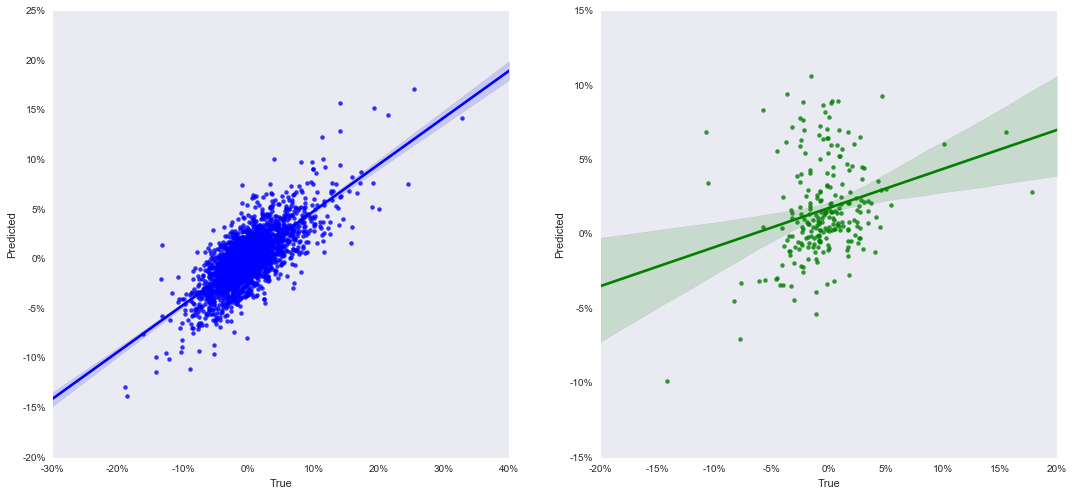

Epoch 20
train loss: 0.0008
train r^2: 0.5333
test loss: 0.0020
test r^2: -0.9391


In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib
sns.set_style('dark')

for i in range(1, epochs+1):
    print('Epoch: {}/{}'.format(i, epochs))
    a.fit(X_train, y_train_reg, validation_split=0.00, verbose=0)
    y_pred_train = a.predict(X_train)
    y_pred_test = a.predict(X_test)
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
    ax = sns.regplot(x=y_train_reg[lookback-1:], y=y_pred_train.ravel(), color='b', ax=ax1)
    ax.set(xlabel='True', ylabel='Predicted')
    ax.set_yticklabels(['{:.0f}%'.format(val*100) for val in ax.get_yticks()])
    ax.set_xticklabels(['{:.0f}%'.format(val*100) for val in ax.get_xticks()])
    ax = sns.regplot(x=y_test_reg[lookback-1:], y=y_pred_test.ravel(), color='g', ax=ax2)
    ax.set(xlabel='True', ylabel='Predicted')
    ax.set_yticklabels(['{:.0f}%'.format(val*100) for val in ax.get_yticks()])
    ax.set_xticklabels(['{:.0f}%'.format(val*100) for val in ax.get_xticks()])
    plt.show()
    
    train_mse, train_r2, test_mse, test_r2 = metrics.mean_squared_error(y_train_reg[lookback-1:], y_pred_train), \
                                             metrics.r2_score(y_train_reg[lookback-1:], y_pred_train), \
                                             metrics.mean_squared_error(y_test_reg[lookback-1:], y_pred_test), \
                                             metrics.r2_score(y_test_reg[lookback-1:], y_pred_test)
    loss_history['train_mse'].append(train_mse)
    loss_history['train_r2'].append(train_r2)
    loss_history['test_mse'].append(test_mse)
    loss_history['test_r2'].append(test_r2)
    print('Epoch {}\ntrain loss: {:.4f}\ntrain r^2: {:.4f}\ntest loss: {:.4f}\ntest r^2: {:.4f}'.format(i,train_mse, train_r2, test_mse, test_r2))

In [22]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
pd.DataFrame(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True))

,0,1
0,X_test_df,336888
1,X_test,335040
2,y_train_reg,122232
3,mapping_table,23573
4,y_train,10168
5,y_pred_train,10148
6,LSTM,3992
7,y_test_reg,3896
8,Dense,2456
9,Sequential,2456


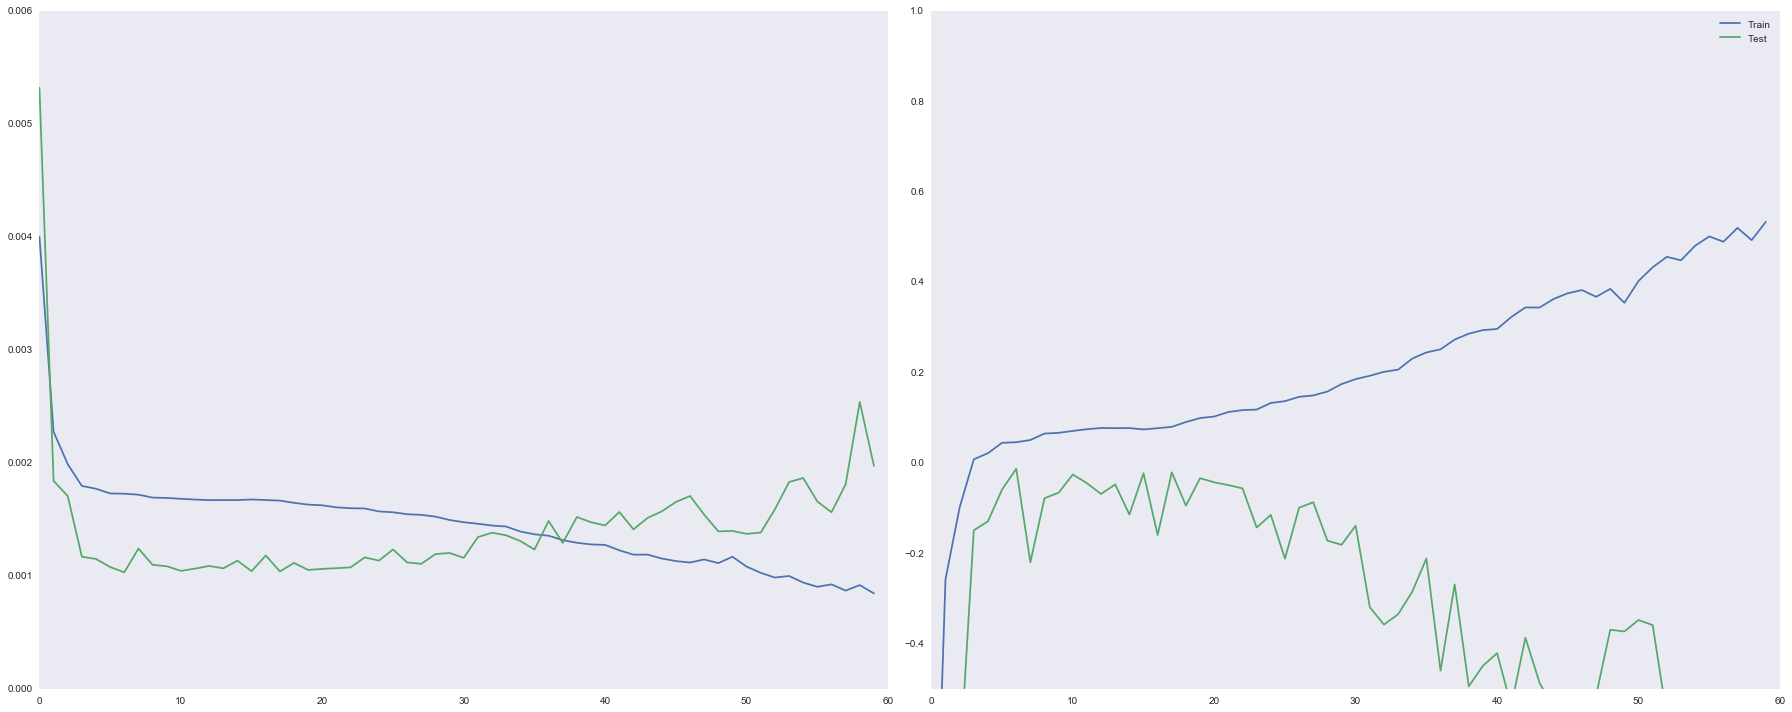

In [17]:
fix, ax = plt.subplots(1, 2, figsize=(25, 10))
ax[0].plot(loss_history['train_mse'], label='Train')
ax[0].plot(loss_history['test_mse'], label='Test')
ax[1].plot(loss_history['train_r2'], label='Train')
ax[1].plot(loss_history['test_r2'], label='Test')
plt.ylim(ymin=-0.5)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
##########################################################################################################################################################
n_splits = 20
##########################################################################################################################################################

pipeline_scale = Pipeline([
#     ('features', FeatureExtractor())
    ('scale', preprocessing.StandardScaler()),
#     ('pca', decomposition.PCA(n_components=60)),
])

my_pipeline = pipeline_scale #pipeline_select_features# my_pipeline_fs3# pipeline_select_features 
# X_train = my_pipeline.fit_transform(X_train)
# X_test = my_pipeline.fit_transform(X_test)
# X, y , y_reg = get_dataset(how='classification', to_date='2017-06-07')
df_predictions_clf = pd.DataFrame(index=y_test_reg.index)
clfs_with_prob = []

# X_train = pd.DataFrame(my_pipeline.fit_transform(X_train, y), index=X_train.index) # use for given feature set passed in a list using pipeline_select_features
# X_test  = pd.DataFrame(my_pipeline.transform(X_test), index=X_test.index)
test_dates = X_test_df.index
X_train = np.array(my_pipeline.fit_transform(X_train_df)) # use for given feature set passed in a list using pipeline_select_features
X_test  = np.array(my_pipeline.transform(X_test_df))

for clf_name in tqdm_notebook(sk_zoo_list):
    clf = sk_zoo_list[clf_name]
    clf.fit(X_train, y_train)
    if hasattr(clf, 'predict_proba'):
        predictions = clf.predict_proba(X_test)[:,0]
    else:
        predictions = clf.predict(X_test)
    df_predictions_clf.loc[test_dates[-len(predictions):], clf_name] = predictions

# Create train and validation sets
# tscv = model_selection.TimeSeriesSplit(n_splits=n_splits)
# for train_index, test_index in tqdm_notebook(list(tscv.split(X))):
#     X_train, X_test, y_train, y_test, test_dates = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index], X.index[test_index]
#     X_train = pd.DataFrame(my_pipeline.fit_transform(X_train, y), index=X_train.index) # use for given feature set passed in a list using pipeline_select_features
#     X_test  = pd.DataFrame(my_pipeline.transform(X_test), index=X_test.index)

#     for clf_name in sk_zoo_list:
#         clf = sk_zoo_list[clf_name]
#         clf.fit(X_train, y_train)
#         if hasattr(clf, 'predict_proba'):
#             predictions = clf.predict_proba(X_test)[:,0]
#         else:
#             predictions = clf.predict(X_test)
#         df_predictions_clf.loc[test_dates, clf_name] = predictions
        
# plt.hist(df_results_prob['LogisticGS3'], bins=50)

In [ ]:
## POSITIONING DATAFRAME CREATION BASED ON SPECIFIED THRESHOLDS
log_prob_long_threshold = 0.50
log_prob_short_threshold = 0.50

clfs_w_prob, clfs_wo_prob = [clf for clf in sk_zoo_list if hasattr(sk_zoo_list[clf], 'predict_proba')], [clf for clf in sk_zoo_list if not hasattr(sk_zoo_list[clf], 'predict_proba')]
df_returns_clf     = pd.DataFrame(data={'Control': -y_test_reg})
df_positioning_clf = pd.DataFrame(index=y_test_reg.index)
df_positioning_clf[clfs_w_prob] = df_predictions_clf[clfs_w_prob].applymap(lambda x: -1 if x > log_prob_short_threshold else 1 if x < log_prob_long_threshold else 0)
df_positioning_clf[clfs_wo_prob] = df_predictions_clf[clfs_wo_prob].applymap(lambda x: -1 if x < 0 else 1 if x > 0 else 0)
df_predictions_clf = df_predictions_clf[clfs_w_prob]
df_returns_clf = df_positioning_clf.multiply(-df_returns_clf['Control'], axis=0).join(df_returns_clf['Control'])
df_returns_clf, df_predictions_clf, df_positioning_clf = df_returns_clf['2009':], df_predictions_clf['2009':], df_positioning_clf['2009':]
clf_results_dict = {'returns':df_returns_clf, 'predictions':df_predictions_clf, 'positioning':df_positioning_clf}

In [ ]:
plot_results(clf_results_dict, thresholds=(log_prob_short_threshold, log_prob_long_threshold), days_history=252, plot_regression='LSTM')

In [ ]:
summary_periods = [{'from':'2015', 'to':'2017'}, {'from':'2012', 'to':'2017'}, {'from':'2010', 'to':'2017'}]
summary_clf = backtest_summary(df_returns_clf, sample_periods=summary_periods)
try: summary_list_clf
except: summary_list_clf = []
summary_list_clf.append(summary_clf)
summary_list_clf[-1]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import seaborn as sns; sns.set_style("white")
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm_list = [cm] if not isinstance(cm, list) else cm
    title = [title + ' 1', title + ' 2'] if not isinstance(title, list) else title
    fig, ax = plt.subplots(nrows=1, ncols=len(cm_list), figsize=(7*len(cm_list), 5))
    tick_marks = np.arange(len(classes))
    plt.setp(ax, xticks=tick_marks, xticklabels=classes, xlabel='Predicted label',
             yticks=tick_marks, yticklabels=classes, ylabel='True label')
    for k, cm in enumerate(cm_list):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        thresh = cm.mean()
        
        im = ax[k].imshow(cm, interpolation='nearest', cmap=cmap)
        fig.colorbar(im, ax=ax[k])
        ax[k].set_title(title[k]+'\n')
        
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax[k].text(j, i, '{:.0f}%'.format(cm[i, j]*100) if normalize else '{:.2f}'.format(cm[i, j]),
                     horizontalalignment="center", verticalalignment='center',
                     color="white" if cm[i, j] > thresh else "black", fontsize=18)
    plt.show()

In [ ]:
cnf_matrix1 = confusion_matrix(y_train[lookback-1:], y_pred_train)
cnf_matrix2 = confusion_matrix(y_test[lookback-1:], y_pred_test)
plot_confusion_matrix([cnf_matrix1, cnf_matrix2], classes=['Up','Down'], normalize=True,
                      title=['Confusion matrix train', 'Confusion matrix test'])

In [ ]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import LSTM, Embedding, Dropout
from keras.utils.np_utils import to_categorical
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import time

class MyLSTMTest(LSTM):
    
    def __init__(self, lstm_layers, activation='linear', loss='mse', metrics=None, optimizer='adam', epochs=10, batch_size=128, step=1, lookback=1, y_to_categorical=True, y_sub={}, **kwargs):
    
        self.lstm_layers = lstm_layers
        self.activation = activation
        self.loss = loss
        self.metrics = metrics
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.step = step
        self.lookback = lookback
        self.kwargs = kwargs
        self.y_to_categorical = y_to_categorical
        self.fitted = False
        self.y_sub = y_sub
        self.y_sub_rev = {v:k for k, v in self.y_sub.items()}
    
    def fit(self, X, y, validation_split=0.0, verbose=2):
        
        self.X_orig = X
        self.y_orig = y
        self.verbose = verbose
        X_, y_ = self._vectorize(X, y)
        self.X_train, self.y_train = X_, y_

        if not self.fitted:        

            # build the model: a single LSTM
            self.model = self.build_model(X_, y_)
            self.model.fit(X_, y_, batch_size=self.batch_size, epochs=self.epochs, verbose=verbose)
            self.fitted=True
        else:
            self.model.fit(X_, y_, batch_size=self.batch_size, epochs=self.epochs, validation_split=validation_split, verbose=verbose)

    def build_model(self, X_, y_):
        
        model = Sequential()

        model.add(LSTM(
            self.lstm_layers[0],
            input_shape=(X_.shape[1], X_.shape[2]),
            return_sequences=False))
        model.add(Dropout(0.2))

#         model.add(LSTM(
#             layers[2],
#             return_sequences=False))
#         model.add(Dropout(0.2))

        model.add(Dense(units=y_.shape[1]))
        model.add(Activation(self.activation))

        start = time.time()
        model.compile(loss=self.loss, optimizer=self.optimizer)
        print("> Compilation Time : ", time.time() - start)
        return model
    
    def predict(self, X):
        X = self._vectorize(X)
        y_pred = self.model.predict(X, batch_size=self.batch_size)
        if self.y_sub:
            y_pred = np.array([self.y_sub_rev[val] if val in self.y_sub_rev.keys() else val for val in y_pred])
        return y_pred

    def predict_proba(self, X):
        X = self._vectorize(X)
        return self.model.predict_proba(X, batch_size=self.batch_size)

    def evaluate(self, X, y):
        X, y = self._vectorize(X, y)
        return self.model.evaluate(X, y, batch_size=self.batch_size)
    
    def _vectorize(self, X, y=None):
        
        # Vectorization
        dataX, dataY = [], []
        for i in range(len(X)-self.lookback+1):
            a = X[i:(i+self.lookback), :]
            dataX.append(a)
            if y is not None:
                dataY.append(y[i + self.lookback-1])
        dataX = np.array(dataX)
        dataY = np.array(dataY)
        if y is not None:
            if self.y_sub:
                dataY = np.array([self.y_sub[val] if val in self.y_sub.keys() else val for val in dataY])
            dataY = dataY.reshape(-1,1)
            if self.y_to_categorical:
                dataY = to_categorical(dataY)
            self.X_train, self.y_train = dataX, dataY
            return dataX, dataY
        else:
            return dataX